In [9]:
# Trader Performance vs Bitcoin Market Sentiment

## Objective
#The objective of this analysis is to study the relationship between Bitcoin market sentiment
#(Fear vs Greed) and trader performance on the Hyperliquid exchange.
#We analyze profitability, trading activity, and behavior under different sentiment regimes
#to extract actionable insights for smarter trading strategies.

## Execution Environment
#All analysis is performed in **Google Colab**.


In [10]:
## 1. Project Setup

#We first create the required directory structure as per the submission guidelines.


In [11]:
# Create required directories
!mkdir -p csv_files
!mkdir -p outputs


In [12]:
## 2. Upload Data Files

#Upload the following files into the `csv_files/` folder:
#- hyperliquid_trades.csv
#- sentiment.csv


In [15]:
## 3. Import Required Libraries


In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


In [17]:
## 4. Load Datasets


In [18]:
trades = pd.read_csv("csv_files/historical_data.csv")
sentiment = pd.read_csv("csv_files/fear_greed_index.csv")

print(trades.shape)
print(sentiment.shape)


(211224, 16)
(2644, 4)


In [19]:
## 5. Data Description

#Each row in the trader dataset represents a single executed trade.
#Only columns relevant to performance, behavior, and risk are retained.


In [20]:
## 6. Data Cleaning and Column Selection


In [21]:
cols_to_keep = [
    "Account",
    "Coin",
    "Execution Price",
    "Size USD",
    "Side",
    "Direction",
    "Closed PnL",
    "Timestamp IST"
]

trades = trades[cols_to_keep].copy()


In [22]:
## 7. Timestamp Processing


In [24]:
trades["Timestamp IST"] = pd.to_datetime(
    trades["Timestamp IST"],
    dayfirst=True,
    errors="coerce"
)
trades["Date"] = trades["Timestamp IST"].dt.date

trades["Closed PnL"] = trades["Closed PnL"].fillna(0)
trades = trades[trades["Size USD"] > 0]


In [25]:
## 8. Feature Engineering


In [26]:
trades["is_long"] = (trades["Side"] == "Buy").astype(int)
trades["win_trade"] = (trades["Closed PnL"] > 0).astype(int)


In [27]:
## 9. Daily Trader-Level Aggregation

#Trades are aggregated to account–date level to align with daily sentiment data.


In [28]:
daily_trader = (
    trades
    .groupby(["Account", "Date"])
    .agg(
        daily_pnl=("Closed PnL", "sum"),
        trades=("Closed PnL", "count"),
        avg_trade_size_usd=("Size USD", "mean"),
        total_volume_usd=("Size USD", "sum"),
        win_rate=("win_trade", "mean"),
        long_ratio=("is_long", "mean")
    )
    .reset_index()
)

daily_trader.head()


,Account,Date,daily_pnl,trades,avg_trade_size_usd,total_volume_usd,win_rate,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,5089.718249,900880.13,0.000000,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,7976.664412,542413.18,0.000000,0.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,23734.500000,949380.00,0.000000,0.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,28186.666667,338240.00,0.000000,0.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,17248.148148,465700.00,0.444444,0.0


In [29]:
## 10. Performance Normalization


In [30]:
daily_trader["pnl_per_trade"] = (
    daily_trader["daily_pnl"] / (daily_trader["trades"] + 1)
)


In [31]:
## 11. Market Sentiment Processing


In [33]:
print(daily_trader.columns)
print(sentiment.columns)


Index(['Account', 'Date', 'daily_pnl', 'trades', 'avg_trade_size_usd',
       'total_volume_usd', 'win_rate', 'long_ratio', 'pnl_per_trade'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [34]:
# Rename sentiment date column to 'Date' (adjust if needed)
sentiment.rename(columns={"date": "Date"}, inplace=True)



In [36]:
sentiment.rename(columns={"classification": "Classification"}, inplace=True)

In [37]:
sentiment["Date"] = pd.to_datetime(sentiment["Date"]).dt.date
sentiment["sentiment"] = sentiment["Classification"].map({
    "Fear": 0,
    "Greed": 1
})

sentiment.head()


,timestamp,value,Classification,Date,sentiment
0,1517463000,30,Fear,2018-02-01,0.0
1,1517549400,15,Extreme Fear,2018-02-02,NaN
2,1517635800,40,Fear,2018-02-03,0.0
3,1517722200,24,Extreme Fear,2018-02-04,NaN
4,1517808600,11,Extreme Fear,2018-02-05,NaN


In [38]:
## 12. Merge Trader Performance with Sentiment


In [39]:
final_df = daily_trader.merge(
    sentiment[["Date", "sentiment"]],
    on="Date",
    how="inner"
)

final_df.head()


,Account,Date,daily_pnl,trades,avg_trade_size_usd,total_volume_usd,win_rate,long_ratio,pnl_per_trade,sentiment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,5089.718249,900880.13,0.000000,0.0,0.000000,NaN
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,7976.664412,542413.18,0.000000,0.0,0.000000,NaN
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,23734.500000,949380.00,0.000000,0.0,0.000000,NaN
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,28186.666667,338240.00,0.000000,0.0,-1632.846154,NaN
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,17248.148148,465700.00,0.444444,0.0,57.253571,NaN


In [40]:
## 13. Exploratory Data Analysis (EDA)


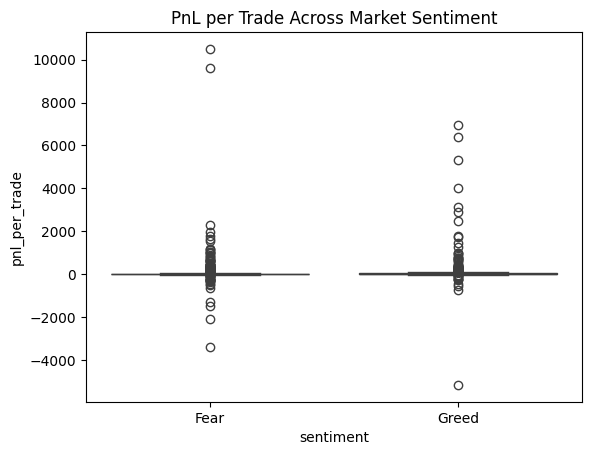

In [41]:
sns.boxplot(x="sentiment", y="pnl_per_trade", data=final_df)
plt.xticks([0, 1], ["Fear", "Greed"])
plt.title("PnL per Trade Across Market Sentiment")
plt.savefig("outputs/pnl_vs_sentiment.png", bbox_inches="tight")
plt.show()


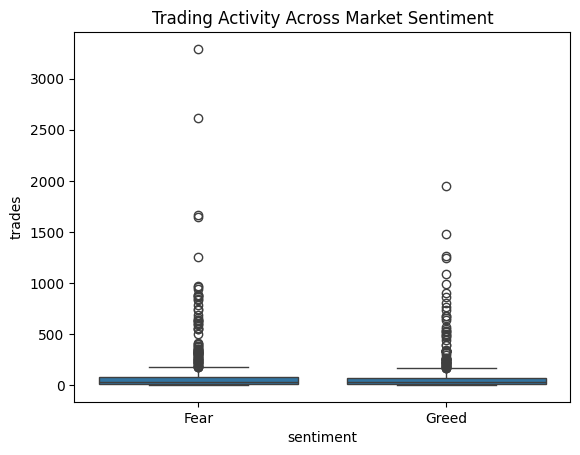

In [42]:
sns.boxplot(x="sentiment", y="trades", data=final_df)
plt.xticks([0, 1], ["Fear", "Greed"])
plt.title("Trading Activity Across Market Sentiment")
plt.savefig("outputs/trades_vs_sentiment.png", bbox_inches="tight")
plt.show()


In [43]:
## 14. Key Insights

#- Trading behavior and profitability differ across sentiment regimes.
#- Higher activity does not guarantee better performance.
#- Risk-normalized metrics provide better insight than raw PnL.


In [44]:
## 16. Save Processed Dataset


In [45]:
final_df.to_csv("csv_files/final_trader_sentiment.csv", index=False)


In [46]:
## 17. Download Outputs


In [47]:
from google.colab import files

files.download("csv_files/final_trader_sentiment.csv")
files.download("outputs/pnl_vs_sentiment.png")
files.download("outputs/trades_vs_sentiment.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>